## Data analysis in figure 5.

To reproduce this notebook, please download following data from [Zenodo repository](https://doi.org/10.5281/zenodo.10925338).

- Sequenced fragments 
  - nih3t3_fragment.zip
- Tables summarizing the datasets
  - nih3t3_metaTable.zip
- MyoD peaks detected by macs2
  - MyoD_peaks_filtered_cluster1.bed
  - MyoD_peaks_filtered_cluster2.bed

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(clusterProfiler)
library(GenomicRanges)
library(chromVAR)
library(motifmatchr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(SummarizedExperiment)

library(tidyverse)
source('mytools.R')



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  inner_join.phylo    tidytree
  inner_join.treedata tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.8.3  For help: https://yulab-smu

In [2]:
meta <- read_tsv('nih3t3_metaTable/RNAP2_MyoD-RNAP2_metaTable.tsv',show_col_types = F) %>%
  filter(sample != "MyoDminus")
summits <- c(
  'nih3t3_MyoD_peaks/MyoD_peaks_filtered_cluster1.bed',
  'nih3t3_MyoD_peaks/MyoD_peaks_filtered_cluster2.bed') %>%
  map2(c('1','2'),~{
    gr <- rtracklayer::import(.x,format = 'bed')
    gr$cluster <- .y
    return(gr)
    }) %>%
  do.call(c,.)
frags <- c(
  'nih3t3_fragment/Pair_MyoD-RNAP2_D0.bed.gz',
  'nih3t3_fragment/Pair_MyoD-RNAP2_D24.bed.gz',
  'nih3t3_fragment/Pair_MyoD-RNAP2_D72.bed.gz') %>%
  map(rtracklayer::import,format = 'bed') %>%
  do.call(c,.)

In [3]:
if(file.exists('data/mgene_ucsc.rds')){
  mgene <- readRDS('data/mgene_ucsc.rds')
}else{
  mgene <- GenomicFeatures::genes(EnsDb.Mmusculus.v79::EnsDb.Mmusculus.v79)
  GenomeInfoDb::seqlevelsStyle(mgene) <- "UCSC"
}
mgene_codings <- mgene %>% subset(gene_biotype=='protein_coding')
idx <- as_tibble(mgene_codings) %>% arrange(-width) %>% filter(!duplicated(symbol)) %>% pull(gene_id)
mgene_codings <- mgene_codings %>% subset(gene_id %in% idx)

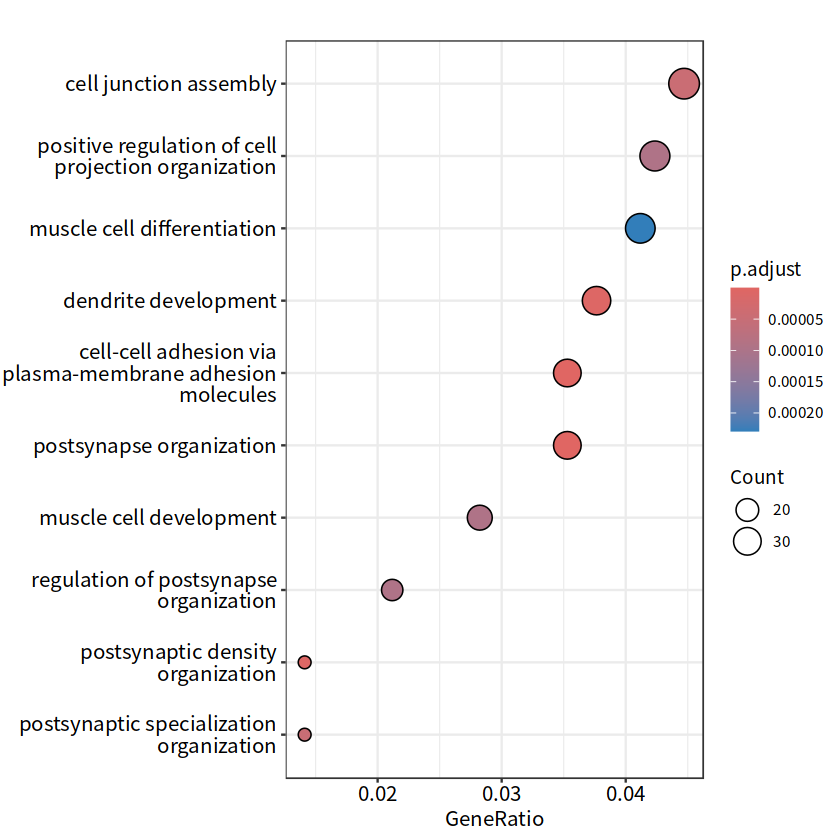

In [4]:
## GO enrichment analysis using all of the genes with MyoD peak

ol_exU5k_all <- summits %>%
  resize(4000,fix = 'center') %>%
  findOverlapPairs(extend(mgene_codings,5000,0)) %>%
  .@second %>% as_tibble() %>% distinct()
onts_exU5k_all <- unique(ol_exU5k_all$symbol) %>%
  enrichGO(OrgDb = org.Mm.eg.db::org.Mm.eg.db,
                            ont = 'BP',keyType = 'SYMBOL')
ontpl1 <- dotplot(onts_exU5k_all,showCategory=10)
ontpl1

### Predict MyoD binding dynamics

In [5]:
## Count MyoD fragments

summits_ol_ud2k <- summits %>%
  resize(width = 4000,fix = 'center') %>%
  findOverlapPairs(frags)
summits_ct_ud2k <- summits_ol_ud2k@first %>%
  as_tibble() %>% count(name)
summits_ol_ud2kf <- bind_cols(
    as_tibble(summits_ol_ud2k@first) %>% select(name) %>% rename(peak = name),
    as_tibble(summits_ol_ud2k@second)%>% select(name) %>% rename(cell = name)
    ) %>%
    inner_join(summits_ct_ud2k,by = c('peak' = 'name')) %>%
    rename(nCount = n) %>%
    select(peak,nCount,cell) %>%
    inner_join(meta,by = 'cell')

In [6]:
## Smooth and normalize MyoD count

mf <- function(x,w) stats::filter(x, filter = dnorm(-w:w))
pt_smooth <- function(ct,Meta,tbin = 30,w = 2){
  tbin_ <- tbin+(2*w)
  nc <- Meta %>%
    filter(!is.na(pt)) %>%
    mutate(
      dpt = (pt-min(pt))/max(pt-min(pt)),
      dpt = floor(tbin_*dpt),
      dpt = ifelse(dpt==tbin_,tbin_,dpt+1)
      ) %>%
    distinct(cell,dpt) %>%
    count(dpt) %>% arrange(dpt) %>% pull(n)
  tmp <- ct %>%
    filter(!is.na(pt)) %>%
    mutate(
      dpt = (pt-min(pt))/max(pt-min(pt)),
      dpt = floor(tbin_*dpt),
      dpt = ifelse(dpt==tbin_,tbin_,dpt+1)
    ) %>%
    count(peak,dpt) %>%
    pivot_wider(names_from = dpt,values_from = n,values_fill = 0)
  ptct <- as.data.frame(tmp[,-1]) %>% as.matrix()
  colnames(ptct) <- colnames(tmp)[-1]
  rownames(ptct) <- tmp$peak
  ptct <- ptct[,as.character(1:tbin_)]
  ptct <- t(t(ptct)/nc)
  ptct <- {ptct/rowSums(ptct)}
  ptct <- log(ptct+1)
  ptct_smoothed <- t(apply(ptct,1,function(x) mf(x,w)))
  colnames(ptct_smoothed) <- colnames(ptct_smoothed)
  ptct_smoothed <- ptct_smoothed[,(1+w):(tbin_-w)]
  colnames(ptct_smoothed) <- as.character(1:tbin)
  return(ptct_smoothed)
}

ptct_smoothed <- pt_smooth(summits_ol_ud2kf,meta)

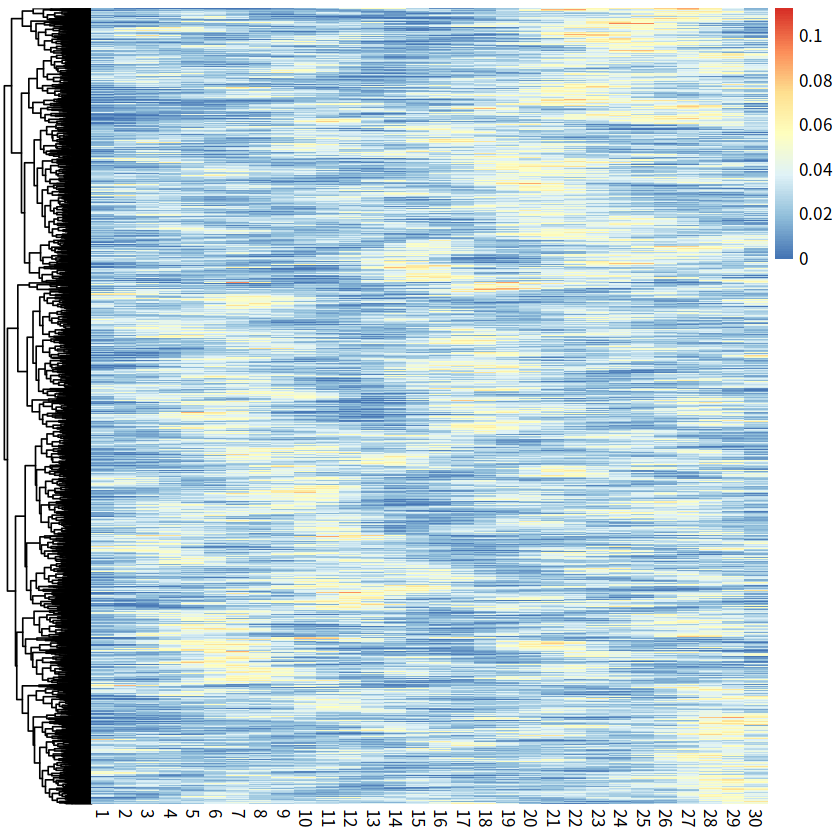

In [7]:
pheatmap::pheatmap(ptct_smoothed,cluster_cols =F,show_rownames = F)

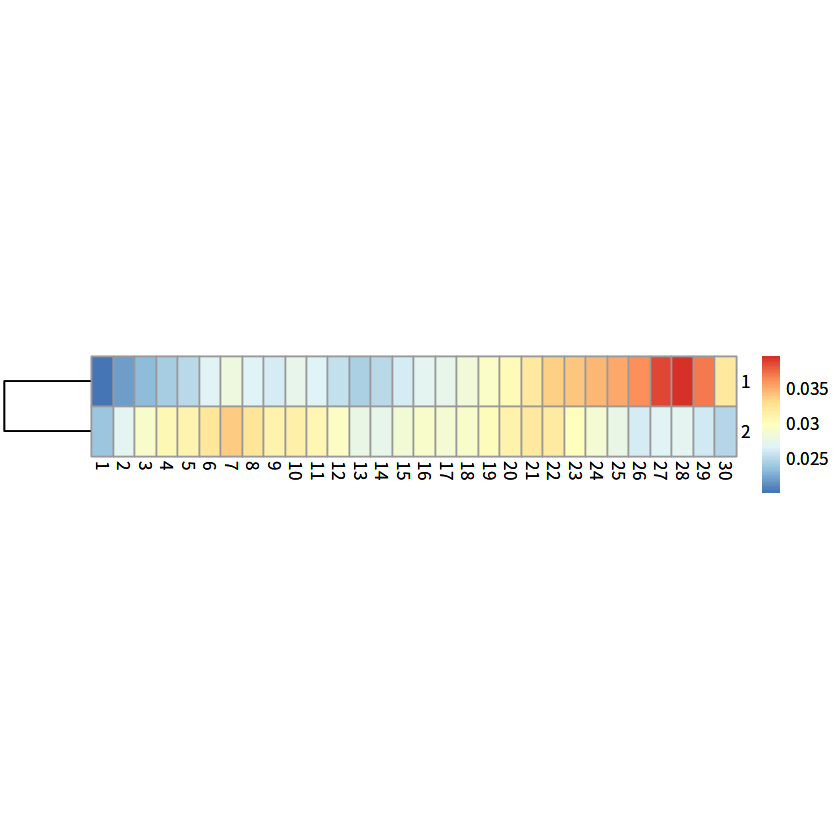

In [8]:
## cluster average

vec <- with(summits,structure(cluster,names = name))
clus <- vec[rownames(ptct_smoothed)]

mod <- model.matrix(~clus -1)
colnames(mod) <- sub("clus","",colnames(mod))
mod <- t(t(mod)/colSums(mod))
summits_ptct_avg_ud2k <- t(t(ptct_smoothed) %*% mod)
gavg <- pheatmap::pheatmap(summits_ptct_avg_ud2k,cluster_cols = F,show_rownames = T,cellheight = 30)
gavg

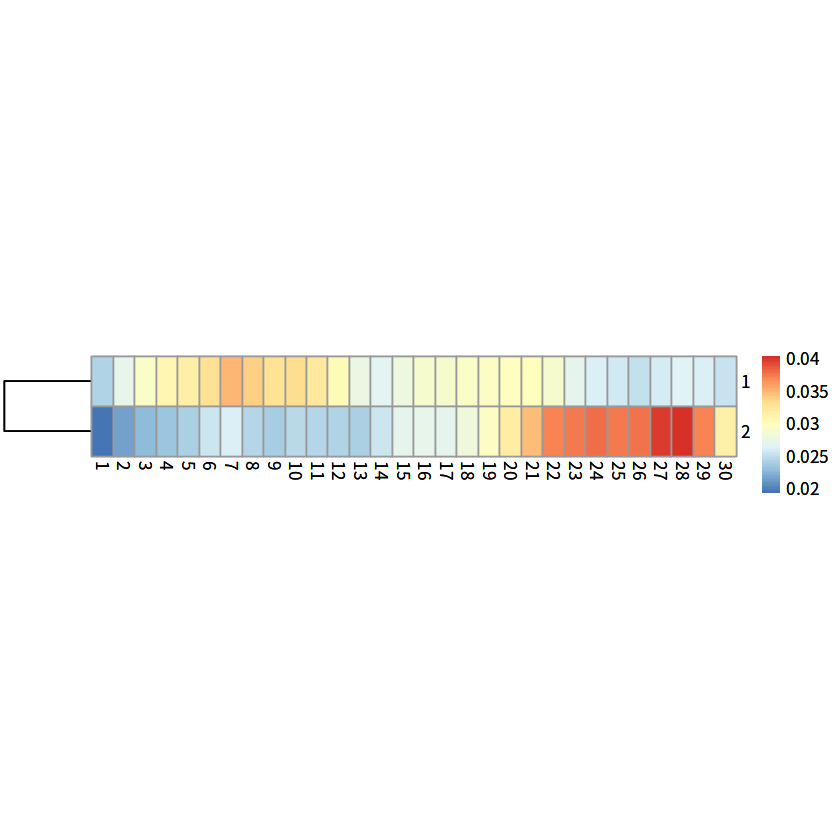

In [9]:
## unfixed

km <- kmeans(ptct_smoothed,centers = 2)$cluster
clus_ <- as.factor(km)

mod <- model.matrix(~clus_ -1)
colnames(mod) <- sub("clus_","",colnames(mod))
mod <- t(t(mod)/colSums(mod))
summits_ptct_avg_ud2k_ <- t(t(ptct_smoothed) %*% mod)
gavg_ <- pheatmap::pheatmap(summits_ptct_avg_ud2k_,cluster_cols = F,show_rownames = T,cellheight = 30)
gavg_

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


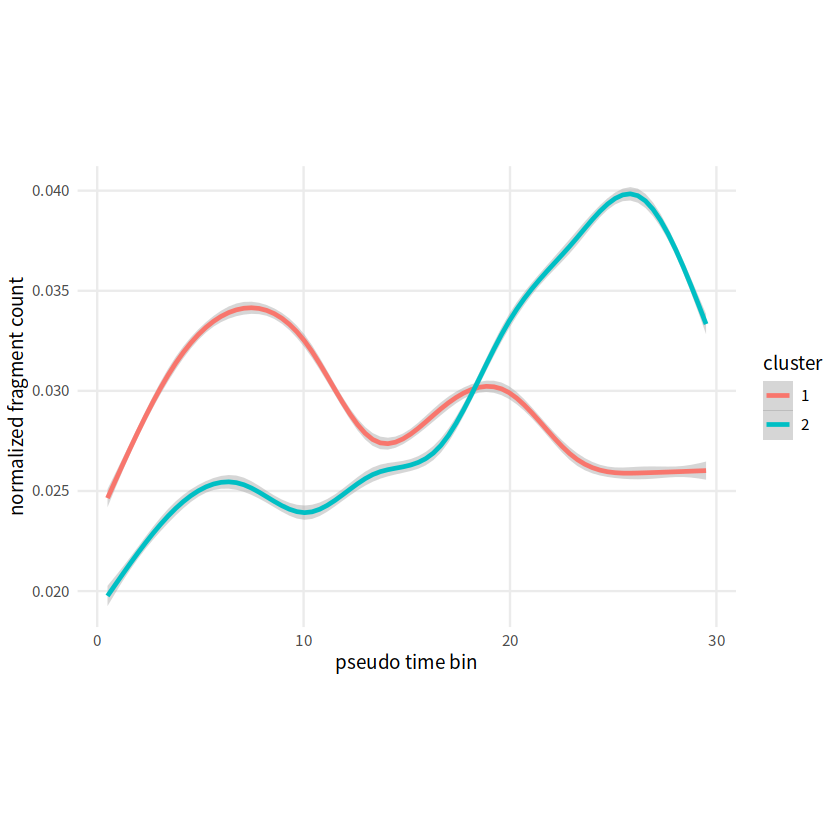

In [10]:
ptct_smoothed2 <- ptct_smoothed %>%
  as_tibble(rownames = 'peak') %>%
  gather(key = pt,value = count,-peak) %>%
  left_join(enframe(clus_),by = c("peak"="name")) %>%
  rename(cluster = value) %>%
  mutate(pt = as.double(pt)-0.5)
mdyn <- ptct_smoothed2 %>%
  ggplot(aes(pt,count,color = cluster)) + 
    theme_minimal() +
    theme(panel.grid.minor = element_blank(),
          aspect.ratio = .7) +
    geom_smooth() + 
    labs(y = "normalized fragment count",x = 'pseudo time bin')
mdyn

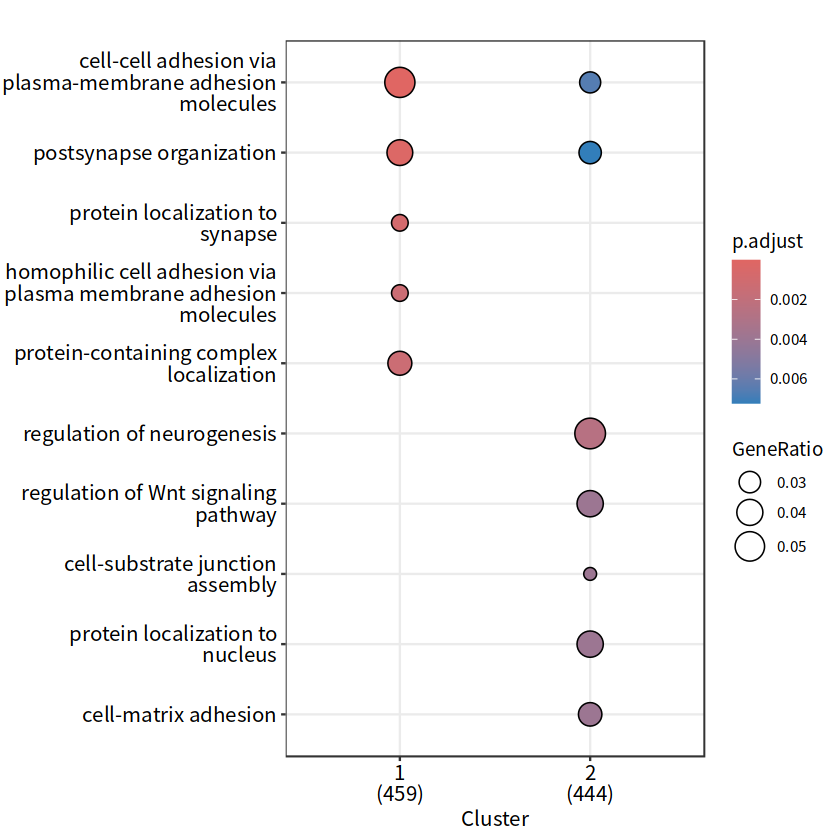

In [11]:
## GO enrichment analysis for each peak cluster

summits_clus <- clus_ %>% enframe() %>%
  with(split(name,value)) %>%
  map(~{
    gr <- summits %>% subset(name %in% .x)
    gr$score <- NULL
    return(gr)
    })
ol_exU5k <- summits_clus %>%
  map(~findOverlapPairs(resize(.x,4000,fix = 'center'),
                        extend(mgene_codings,5000,0))@second %>%
      as_tibble() %>% distinct() )
onts_exU5k <- ol_exU5k %>% 
  map(~unique(.x$symbol)) %>%
  compareCluster(
    OrgDb = org.Mm.eg.db::org.Mm.eg.db,
    ont = 'BP',keyType = 'SYMBOL'
    )
ontpl2 <- dotplot(onts_exU5k)
ontpl2

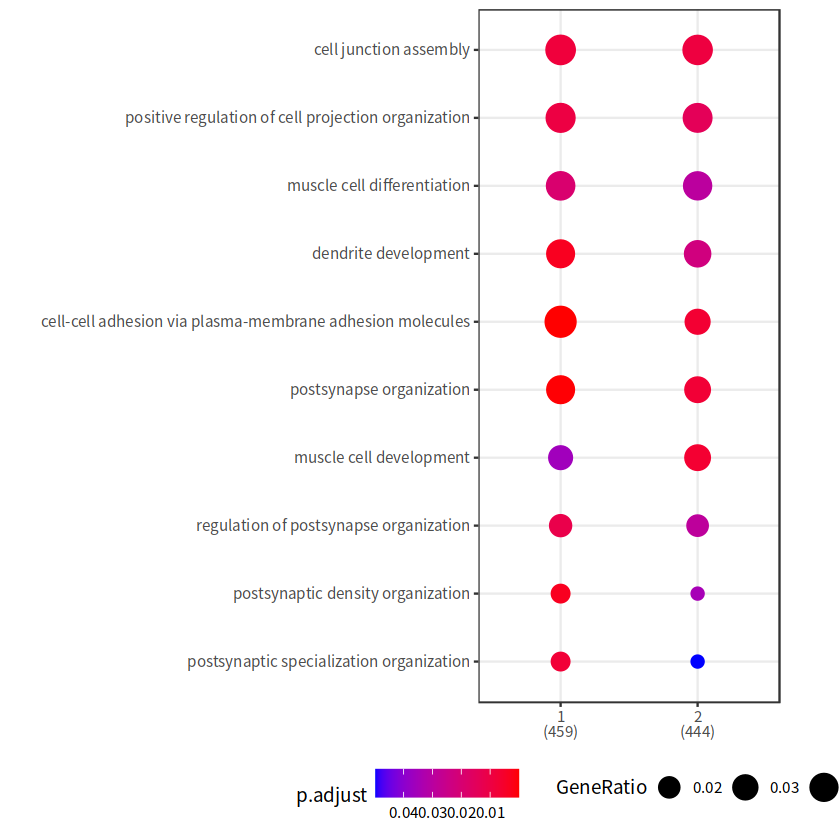

In [12]:
usego <- onts_exU5k_all@result %>% as_tibble() %>% head(10) %>% 
  arrange(-Count) %>% pull(Description)
ontpl22 <- onts_exU5k@compareClusterResult %>% as_tibble() %>% filter(Description%in%usego) %>%
  mutate(Description = factor(Description,levels = rev(usego)),
         tot = paste0(sub(".*/","(",GeneRatio),')'),
         GeneRatio = enrichplot:::parse_ratio(GeneRatio)) %>%
  unite(Cluster,Cluster,tot,sep = '\n') %>%
  mutate(Cluster = factor(Cluster,levels = unique(Cluster))) %>%
  ggplot(aes(Cluster,Description,size = GeneRatio,color = p.adjust)) + 
  geom_point() + theme_bw() + 
  enrichplot::set_enrichplot_color(c("red","blue"),type = "color") +
  theme(axis.title = element_blank(),aspect.ratio = 2.3,
        legend.position = 'bottom') +
  scale_size_continuous(range = c(3,8))
ontpl22

In [13]:
## Motif enrichment analysis for each peak cluster

db <- readRDS('data/motifs_pwm.rds') 
## from JASPAR2020 CORE

labs <- tibble(id = names(db)) %>%
  mutate(name = map(id,~{db[[.x]]@name})) %>%
  unnest(name)
bhlh <- read_tsv("data/bHLH_gens.tsv",show_col_types = F) %>%
  select(Clade,Mouse) %>%
  na.omit() %>% mutate(Mouse = str_split(Mouse,', ')) %>%
  unnest(Mouse) %>% mutate(Mouse = sub("\\(.*","",Mouse)) 
## from skinner et. al., Differentiation, 2010

uselab <- labs %>%
  filter(tolower(name) %in% tolower(bhlh$Mouse)) %>%
  pull(id) %>% unique()


In [14]:
tmp <- enframe(clus) %>% rename(peak = name,cluster = value) %>%
  inner_join(summits_ct_ud2k,.,by = c('name'='peak')) %>%
  pivot_wider(names_from = cluster,values_from = n,values_fill = 0)
counts <- as.matrix(as.data.frame(tmp[,-1]))
rownames(counts) <- tmp$name
rowRanges <- summits_clus %>% structure(names = NULL) %>%
  do.call(c,.) %>% resize(4000,fix = 'center')
counts <- counts[rowRanges$name,]

cnt <- SummarizedExperiment(
  assays=list(counts=counts),
  rowRanges=rowRanges
  ) %>%
  addGCBias(genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ixs <- matchMotifs(
  db[uselab], cnt,
  genome =  BSgenome.Mmusculus.UCSC.mm10
  )
dev <- computeDeviations(object = cnt, annotations = motif_ixs)
devZ <- deviationScores(dev)

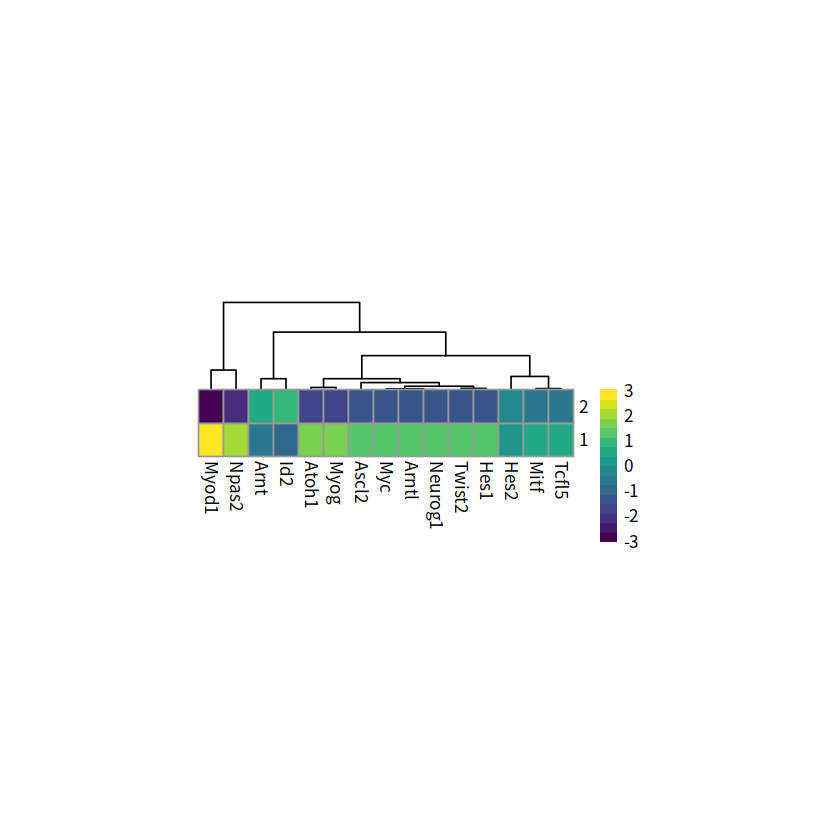

In [15]:
labs_ <- labs %>% filter(id %in% uselab)
devZ2 <- devZ[labs_$id,]
rownames(devZ2) <- labs_$name
devZ2 <- t(devZ2)
pheatmap::pheatmap(devZ2,cluster_rows = F,
                   color = viridis::viridis(16),
                   cellwidth = 15,cellheight = 20)

### Predict the dynamics of other epigenetic features around MyoD peaks

In [16]:
Abs <- c("RNAP2","H3K4me3","H3K27ac","H3K27me3","Brg1","Myog")
pts <- c(
  'RNAP2_MyoD-RNAP2_metaTable.tsv','RNAP2_H3K4me3-RNAP2_metaTable.tsv',
  'RNAP2_H3K27ac-RNAP2_metaTable.tsv','RNAP2_H3K27me3-RNAP2_metaTable.tsv',
  'RNAP2_Brg1-RNAP2_metaTable.tsv','RNAP2_Myog-RNAP2_metaTable.tsv'
  ) %>%
  paste0("nih3t3_metaTable/",.) %>%
  structure(names = Abs) %>%
  map(~read_tsv(.x,show_col_types = F) %>% 
    select(cell,pt) %>% na.omit()
    )

pair_grs <- Abs[-1] %>%
  map(~{
    Ab <- .x
    map(c('D0','D24','D72'),~{
      rtracklayer::import(paste0('nih3t3_fragment/Pair_',Ab,'-RNAP2_',.x,'.bed.gz'),format='bed')
    }) %>% do.call(c,.)
  }) %>%
  structure(names = Abs[-1])
pair_grs[['RNAP2']] <- map(c('D0','D24','D72'),~{
      rtracklayer::import(paste0('nih3t3_fragment/RNAP2_MyoD-RNAP2_',.x,'.bed.gz'))
    }) %>% do.call(c,.)
pair_grs <- pair_grs[Abs]

countInPeaks <- Abs %>%
  map(~{
    query <- .x
    summits_clus %>%
      map(~{
        ol <- findOverlapPairs(resize(.x,10000,fix = 'center'),pair_grs[[query]])
        tibble(peak = ol@first$name,cell = ol@second$name)
        }) %>%
      bind_rows(.id = 'cluster') %>%
      inner_join(pts[[query]],by = 'cell')
    }) %>%
  structure(names = Abs)
head(countInPeaks[["H3K4me3"]])

cluster,peak,cell,pt
<chr>,<chr>,<chr>,<dbl>
1,MyoD_peak_54,RNAP2_H3K4me3_r1_D0_S79_GATCCT,0.012370849
1,MyoD_peak_54,RNAP2_H3K4me3_r1_D0_S13_CACCAT,0.022846403
1,MyoD_peak_54,RNAP2_H3K4me3_r1_D0_S62_CATCTG,0.007639683
1,MyoD_peak_54,RNAP2_H3K4me3_r1_D0_S6_GACGTA,0.008888751
1,MyoD_peak_54,RNAP2_H3K4me3_r1_D0_S6_GACGTA,0.008888751
1,MyoD_peak_54,RNAP2_H3K4me3_r1_D0_S55_CCACTA,0.018025520


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


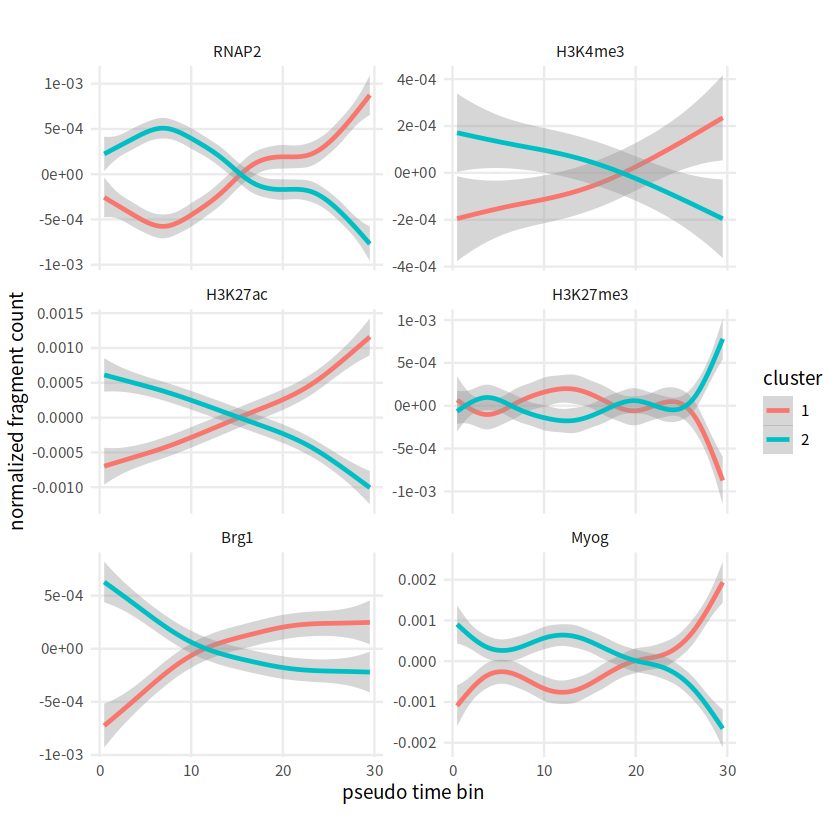

In [17]:
ptct_smoothed_abs <- Abs %>%
  map(~pt_smooth(countInPeaks[[.x]],pts[[.x]],tbin = 30,w=2)) %>%
  map(scale,scale = F) %>%
  structure(names = Abs) 
ptct_smoothed_abs2 <- ptct_smoothed_abs %>%
  map(~{
    .x %>% 
      as_tibble(rownames = 'peak') %>%
      gather(key = pt,value = count,-peak) %>%
      left_join(enframe(clus),by = c("peak"="name")) %>%
      rename(cluster = value) %>%
      mutate(pt = as.double(pt)-0.5)
  }) %>%
  bind_rows(.id = 'Ab')
dyn <- ptct_smoothed_abs2 %>%
  mutate(Ab = factor(Ab,levels = Abs)) %>%
  ggplot(aes(pt,count,color = cluster)) + 
    theme_minimal() +
    theme(panel.grid.minor = element_blank(),
          aspect.ratio = .7) +
    geom_smooth() + 
    labs(y = "normalized fragment count",x = 'pseudo time bin') +
    facet_wrap(~Ab,scales = 'free_y',ncol = 2)
dyn

In [18]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3                    forcats_1.0.0                     
 [3] stringr_1.5.1                      dplyr_1.1.4                       
 [5] purrr_1.0.2                        readr_2.1.5                       
